<a href="https://colab.research.google.com/github/noraboucetta/mimic_project/blob/main/mimicproject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
import os
import re
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import AutoTokenizer, AutoModel
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm

In [128]:
# ===== CONFIGURATION GÉNÉRALE =====
# Utilisation du GPU si disponible
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Configuration optimisée pour Colab + ResNet-18
BATCH_SIZE = 32     # ResNet-18 est léger, on peut garder 32
IMG_SIZE = 256      # Taille standard
MAX_LEN = 128       # Longueur max du texte pour BERT
LR = 5e-4           # Learning rate
EPOCHS = 20         # Nombre d'époques
PATIENCE = 3        # Arrêt anticipé si pas d'amélioration

In [129]:
# ==============================================================================
# 1. LABELER CHEXPERT V3 (CORRIGÉ : GÈRE "STABLE", "NORMAL", "UNCHANGED")
# ==============================================================================
class CheXpertLabelerV3:
    def __init__(self):
        # Mots-clés des pathologies
        self.patterns = {
            "Cardiomegaly": [
                "cardiomegaly", "enlarged heart", "heart size", "cardiac silhouette",
                "enlargement of the heart", "cardiomediastinal silhouette"
            ],
            "Lung Lesion": [
                "lung lesion", "nodule", "mass", "tumor", "neoplasm",
                "granuloma", "hamartoma", "opacities", "opacity"
            ],
            "Pleural Effusion": [
                "pleural effusion", "effusion", "liquid", "fluid in the pleural",
                "blunting", "costophrenic angle"
            ],
            "Support Devices": [
                "pacemaker", "catheter", "tube", "line", "wire", "device",
                "clip", "prosthesis", "picc", "port-a-cath", "sternotomy"
            ],
            "No Finding": [
                "no acute", "no abnormality", "normal chest", "clear lungs",
                "unremarkable", "normal examination"
            ]
        }

        # Liste des mots qui ANNULENT la maladie (Négation stricte)
        self.negations = [
            r"\bno\b", r"\bnot\b", r"\bwithout\b", r"\bfree of\b",
            r"\bnegative\b", r"\babsence of\b", r"\bresolved\b",
            r"\bruled out\b"
        ]

        # --- CORRECTION MAJEURE ICI ---
        # Termes de "Normalité" qui annulent une pathologie même si le mot clé est présent.
        # Ex: "Heart size (Pattern) is normal (Modifier)" -> Label = 0
        self.normal_modifiers = [
            r"\bnormal\b", r"\bstable\b", r"\bunchanged\b",
            r"\bunremarkable\b", r"\bwithin normal limits\b"
        ]

    def clean_report(self, report):
        report = report.lower()
        report = re.sub(r'\[\*\*.*?\*\*\]', ' ', report) # Supprime anonymisation
        report = re.sub(r'[^\w\s\.]', ' ', report)       # Garde les points
        report = re.sub(r'\s+', ' ', report).strip()
        return report

    def get_labels(self, report):
        report = self.clean_report(report)
        labels = {k: 0.0 for k in self.patterns.keys()}

        # On découpe par phrase pour éviter les confusions lointaines
        sentences = report.split('.')

        for sentence in sentences:
            if len(sentence) < 3: continue

            # Vérification des Pathologies
            for path in ["Cardiomegaly", "Lung Lesion", "Pleural Effusion", "Support Devices"]:
                for word in self.patterns[path]:
                    if word in sentence:
                        # 1. Est-ce nié ? (ex: "No cardiomegaly")
                        is_negated = any(re.search(neg, sentence) for neg in self.negations)

                        # 2. Est-ce qualifié de normal ? (ex: "Heart size is normal")
                        is_normal = any(re.search(mod, sentence) for mod in self.normal_modifiers)

                        # Si ce n'est NI nié, NI normal -> C'est une maladie
                        if not is_negated and not is_normal:
                            labels[path] = 1.0

                            # Exception : Si on dit explicitement "is seen" ou "is present", c'est positif
                            if "seen" in sentence or "present" in sentence:
                                if not is_negated: labels[path] = 1.0

        # Gestion No Finding (Priorité aux pathologies)
        pathology_sum = sum([labels[p] for p in ["Cardiomegaly", "Lung Lesion", "Pleural Effusion", "Support Devices"]])
        if pathology_sum > 0:
            labels["No Finding"] = 0.0
        else:
            # Si aucune maladie trouvée, on vérifie si des termes "sains" sont présents
            for word in self.patterns["No Finding"]:
                if word in report: # Ici on regarde tout le rapport
                    labels["No Finding"] = 1.0
                    break
            # Si le rapport est vide de pathologies, on met No Finding par défaut
            if pathology_sum == 0: labels["No Finding"] = 1.0

        return [
            labels["No Finding"], labels["Cardiomegaly"], labels["Lung Lesion"],
            labels["Pleural Effusion"], labels["Support Devices"]
        ]

labeler = CheXpertLabelerV3()

In [90]:
# ===== 1. Décompresser le fichier zip =====
zip_path = "/content/archive5.rar"  # mettre le chemin correct
output_dir = "/content/mimic-cxr-dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

TEXT_ROOT = os.path.join(output_dir, "mimic-cxr-dataset/mimic-cxr-reports/files")
IMAGE_ROOT = os.path.join(output_dir, "mimic-cxr-dataset/official_data_iccv_final/files")

In [130]:
TEXT_ROOT = os.path.join(output_dir, "mimic-cxr-dataset/mimic-cxr-reports/files")
IMAGE_ROOT = os.path.join(output_dir, "mimic-cxr-dataset/official_data_iccv_final/files")
# ===== 2. CREATION DU DATAFRAME =====
def create_dataframe(text_root, image_root):
    data = []
    if not os.path.exists(text_root):
        print("❌ Erreur : Dossier texte introuvable.")
        return pd.DataFrame()

    patients = [p for p in os.listdir(text_root) if os.path.isdir(os.path.join(text_root, p))]

    for p in tqdm(patients, desc="Indexation des patients"):
        patient_path = os.path.join(text_root, p)
        for subj in os.listdir(patient_path):
            subj_path = os.path.join(patient_path, subj)
            if not os.path.isdir(subj_path):
                continue

            txt_files = [f for f in os.listdir(subj_path) if f.endswith('.txt')]
            if not txt_files:
                continue

            try:
                with open(os.path.join(subj_path, txt_files[0]), 'r') as f:
                    report = f.read()
            except:
                continue

            labels = labeler.get_labels(report)
            study_id = txt_files[0].replace('.txt', '')
            img_dir = os.path.join(image_root, p, subj, study_id)
            if not os.path.exists(img_dir):
                continue

            imgs = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg')]
            if imgs:
                # On prend la première image de l'étude
                data.append([report, imgs[0], *labels])

    return pd.DataFrame(data, columns=["report", "img_path", "No Finding", "Cardiomegaly", "Lung Lesion",
                                       "Pleural Effusion", "Support Devices"])


df = create_dataframe(TEXT_ROOT, IMAGE_ROOT)

if len(df) == 0:
    raise ValueError("Le DataFrame est vide. Vérifiez vos chemins d'accès !")

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"✅ Données chargées : {len(train_df)} train, {len(val_df)} validation")


Indexation des patients: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

✅ Données chargées : 3600 train, 900 validation


In [131]:
# ===== 3. DATASET & DATALOADER =====
class MimicDataset(Dataset):
    def __init__(self, df, tokenizer, is_train=True):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.is_train = is_train
        self.transform = self.get_transform(is_train)

    def get_transform(self, is_train):
        if is_train:
            return transforms.Compose([
                transforms.Resize((270, 270)),
                transforms.RandomCrop(IMG_SIZE),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        return transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Chargement Image
        try:
            img = Image.open(row['img_path']).convert('RGB')
        except:
            # Image noire en cas d'erreur de lecture pour ne pas planter
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE))

        img = self.transform(img)

        # Tokenization Texte
        enc = self.tokenizer(row['report'], truncation=True, padding='max_length', max_length=MAX_LEN, return_tensors='pt')

        # Labels
        labels = torch.tensor(row.iloc[2:].values.astype(float), dtype=torch.float)

        return img, enc['input_ids'].squeeze(0), enc['attention_mask'].squeeze(0), labels

# Initialisation du tokenizer BERT
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

train_dl = DataLoader(MimicDataset(train_df, tokenizer, True), batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(MimicDataset(val_df, tokenizer, False), batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

# ===== 4. ASYMMETRIC LOSS (Pour gérer le déséquilibre des classes) =====
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=2, gamma_pos=0, clip=0.0):
        super().__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip

    def forward(self, x, y):
        x_sigmoid = torch.sigmoid(x)
        xs_pos, xs_neg = x_sigmoid, 1 - x_sigmoid
        if self.clip > 0: xs_neg = (xs_neg + self.clip).clamp(max=1)
        loss_pos = y * torch.log(xs_pos.clamp(min=1e-8))
        loss_neg = (1 - y) * torch.log(xs_neg.clamp(min=1e-8))
        return -1 * (self.gamma_pos * loss_pos + self.gamma_neg * loss_neg).sum()


In [132]:

# ===== 5. MODÈLE RESNET-18 MULTIMODAL =====
class ResNet18Multimodal(nn.Module):
    def __init__(self):
        super().__init__()

        # --- Branche Image : ResNet-18 ---
        self.img_model = models.resnet18(weights='DEFAULT')
        num_ftrs = self.img_model.fc.in_features
        self.img_model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512), # Stabilise la sortie image
            nn.SiLU()
        )

        # --- Branche Texte : ClinicalBERT ---
        self.bert = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        # On gèle BERT mais on laisse la dernière couche de l'encodeur apprendre
        for param in self.bert.parameters():
            param.requires_grad = False
        for param in self.bert.encoder.layer[-1].parameters():
            param.requires_grad = True

        self.txt_proj = nn.Sequential(
            nn.Linear(768, 512),
            nn.BatchNorm1d(512),
            nn.SiLU()
        )

        # --- Classifieur Final ---
        # Augmentation du Dropout à 0.5 pour lutter contre l'overfitting
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 5)
        )

    def forward(self, img, ids, mask):
        # Features Image
        img_f = self.img_model(img)

        # Features Texte (Mean Pooling)
        txt_out = self.bert(ids, mask).last_hidden_state
        mask_ex = mask.unsqueeze(-1).expand(txt_out.size()).float()
        txt_f = torch.sum(txt_out * mask_ex, 1) / torch.clamp(mask_ex.sum(1), min=1e-9)
        txt_f = self.txt_proj(txt_f)

        # Fusion par concaténation
        combined = torch.cat((img_f, txt_f), dim=1)
        return self.classifier(combined)

In [133]:
# Initialisation du modèle et outils
model = ResNet18Multimodal().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_dl), epochs=20)
scaler = torch.amp.GradScaler('cuda')
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0, 5.0, 5.0, 5.0, 3.0]).to(DEVICE))

# Paramètres Early Stopping
PATIENCE = 3
counter = 0
best_val_loss = float('inf')

print(f"🚀 Démarrage de l'entraînement (Max 20 époques)... Target: Minimiser la Loss Val")

for epoch in range(20):
    # --- PHASE ENTRAÎNEMENT ---
    model.train()
    train_loss = 0
    loop = tqdm(train_dl, desc=f"Epoch {epoch+1}")

    for img, ids, mask, labels in loop:
        img, ids, mask, labels = img.to(DEVICE), ids.to(DEVICE), mask.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            outputs = model(img, ids, mask)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    # --- PHASE VALIDATION ---
    model.eval()
    val_loss = 0
    y_preds, y_true = [], []

    with torch.no_grad():
        for img, ids, mask, labels in val_dl:
            img, ids, mask, labels = img.to(DEVICE), ids.to(DEVICE), mask.to(DEVICE), labels.to(DEVICE)
            with torch.amp.autocast('cuda'):
                outputs = model(img, ids, mask)
                v_loss = criterion(outputs, labels)
                val_loss += v_loss.item()

            y_preds.append(torch.sigmoid(outputs).cpu())
            y_true.append(labels.cpu())

    avg_val_loss = val_loss / len(val_dl)
    y_preds = torch.cat(y_preds).numpy()
    y_true = torch.cat(y_true).numpy()
    f1 = f1_score(y_true, (y_preds > 0.4).astype(int), average='micro')

    print(f"📊 Epoch {epoch+1} Summary | Train Loss: {train_loss/len(train_dl):.4f} | Val Loss: {avg_val_loss:.4f} | F1: {f1:.4f}")

    # --- LOGIQUE D'ARRÊT ET SAUVEGARDE ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model_multimodal.pt")
        print(f" Amélioration détectée ! Modèle sauvegardé.")
        counter = 0
    else:
        counter += 1
        print(f" Pas d'amélioration de la Loss ({counter}/{PATIENCE})")
        if counter >= PATIENCE:
            print("🛑 Arrêt précoce (Early Stopping) déclenché. Le modèle commençait à surapprendre.")
            break

🚀 Démarrage de l'entraînement (Max 20 époques)... Target: Minimiser la Loss Val


Epoch 1: 100%|██████████| 113/113 [00:28<00:00,  3.93it/s, loss=0.656]


📊 Epoch 1 Summary | Train Loss: 0.8981 | Val Loss: 0.6991 | F1: 0.5932
 Amélioration détectée ! Modèle sauvegardé.


Epoch 2: 100%|██████████| 113/113 [00:28<00:00,  3.97it/s, loss=0.52]


📊 Epoch 2 Summary | Train Loss: 0.6085 | Val Loss: 0.5107 | F1: 0.7003
 Amélioration détectée ! Modèle sauvegardé.


Epoch 3: 100%|██████████| 113/113 [00:28<00:00,  3.99it/s, loss=0.402]


📊 Epoch 3 Summary | Train Loss: 0.4830 | Val Loss: 0.4800 | F1: 0.7516
 Amélioration détectée ! Modèle sauvegardé.


Epoch 4: 100%|██████████| 113/113 [00:28<00:00,  3.94it/s, loss=0.807]


📊 Epoch 4 Summary | Train Loss: 0.4349 | Val Loss: 0.5062 | F1: 0.7541
 Pas d'amélioration de la Loss (1/3)


Epoch 5: 100%|██████████| 113/113 [00:28<00:00,  3.95it/s, loss=0.375]


📊 Epoch 5 Summary | Train Loss: 0.4256 | Val Loss: 0.5504 | F1: 0.6804
 Pas d'amélioration de la Loss (2/3)


Epoch 6: 100%|██████████| 113/113 [00:28<00:00,  3.95it/s, loss=0.439]


📊 Epoch 6 Summary | Train Loss: 0.3980 | Val Loss: 0.5872 | F1: 0.8078
 Pas d'amélioration de la Loss (3/3)
🛑 Arrêt précoce (Early Stopping) déclenché. Le modèle commençait à surapprendre.


In [135]:
import numpy as np
from sklearn.metrics import f1_score
import torch

def optimize_thresholds(model, dataloader, device):
    model.eval()
    y_true_list = []
    y_probs_list = []

    print("🔍 Recherche des seuils optimaux...")

    with torch.no_grad():
        for img, ids, mask, labels in dataloader:
            img, ids, mask = img.to(device), ids.to(device), mask.to(device)
            logits = model(img, ids, mask)
            probs = torch.sigmoid(logits)

            y_probs_list.append(probs.cpu().numpy())
            y_true_list.append(labels.cpu().numpy())

    y_true_continuous = np.concatenate(y_true_list)
    y_probs = np.concatenate(y_probs_list)

    # Binariser les vrais labels (si label smoothing utilisé)
    y_true = (y_true_continuous > 0.5).astype(int)

    # Liste des pathologies
    pathologies = ["No Finding", "Cardiomegaly", "Lung Lesion", "Pleural Effusion", "Support Devices"]
    best_thresholds = []

    print("\n=== RÉSULTATS OPTIMISATION ===")

    # Tester les seuils de 0.05 à 0.60
    thresholds_range = np.arange(0.05, 0.60, 0.01)

    for i, path in enumerate(pathologies):
        best_f1 = 0
        best_th = 0.5

        # On extrait les colonnes correspondantes
        y_true_cls = y_true[:, i]
        y_score_cls = y_probs[:, i]

        for th in thresholds_range:
            y_pred_cls = (y_score_cls >= th).astype(int)
            score = f1_score(y_true_cls, y_pred_cls, zero_division=0)

            if score > best_f1:
                best_f1 = score
                best_th = th

        best_thresholds.append(best_th)
        print(f"{path:20s} | Meilleur Seuil: {best_th:.2f} | Nouveau F1: {best_f1:.4f}")

    return best_thresholds

# 1. Calculer les meilleurs seuils
optimal_thresholds = optimize_thresholds(model, val_dl, DEVICE)

# 2. Fonction pour utiliser ces seuils lors de la prédiction finale
def predict_with_optimized_thresholds(probs, thresholds):
    # probs: vecteur de probabilités [0.1, 0.8, ...]
    # thresholds: liste des seuils [0.3, 0.4, ...]
    predictions = []
    for i, p in enumerate(probs):
        pred = 1 if p >= thresholds[i] else 0
        predictions.append(pred)
    return predictions

print(f"\n✅ Seuils finaux à copier-coller : {optimal_thresholds}")

🔍 Recherche des seuils optimaux...

=== RÉSULTATS OPTIMISATION ===
No Finding           | Meilleur Seuil: 0.58 | Nouveau F1: 0.8843
Cardiomegaly         | Meilleur Seuil: 0.38 | Nouveau F1: 0.6991
Lung Lesion          | Meilleur Seuil: 0.59 | Nouveau F1: 0.8031
Pleural Effusion     | Meilleur Seuil: 0.40 | Nouveau F1: 0.8493
Support Devices      | Meilleur Seuil: 0.55 | Nouveau F1: 0.7793

✅ Seuils finaux à copier-coller : [np.float64(0.5800000000000002), np.float64(0.38000000000000006), np.float64(0.5900000000000002), np.float64(0.4000000000000001), np.float64(0.5500000000000002)]


In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

📊 Calcul des métriques avec seuils optimisés : [0.57, 0.59, 0.57, 0.45, 0.59]

RAPPORT DE CLASSIFICATION FINAL
                  precision    recall  f1-score   support

      No Finding       0.85      0.92      0.88       444
    Cardiomegaly       0.78      0.55      0.65       118
     Lung Lesion       0.71      0.91      0.80       168
Pleural Effusion       0.84      0.84      0.84       143
 Support Devices       0.74      0.82      0.78       237

       micro avg       0.79      0.85      0.82      1110
       macro avg       0.78      0.81      0.79      1110
    weighted avg       0.80      0.85      0.82      1110
     samples avg       0.83      0.87      0.84      1110



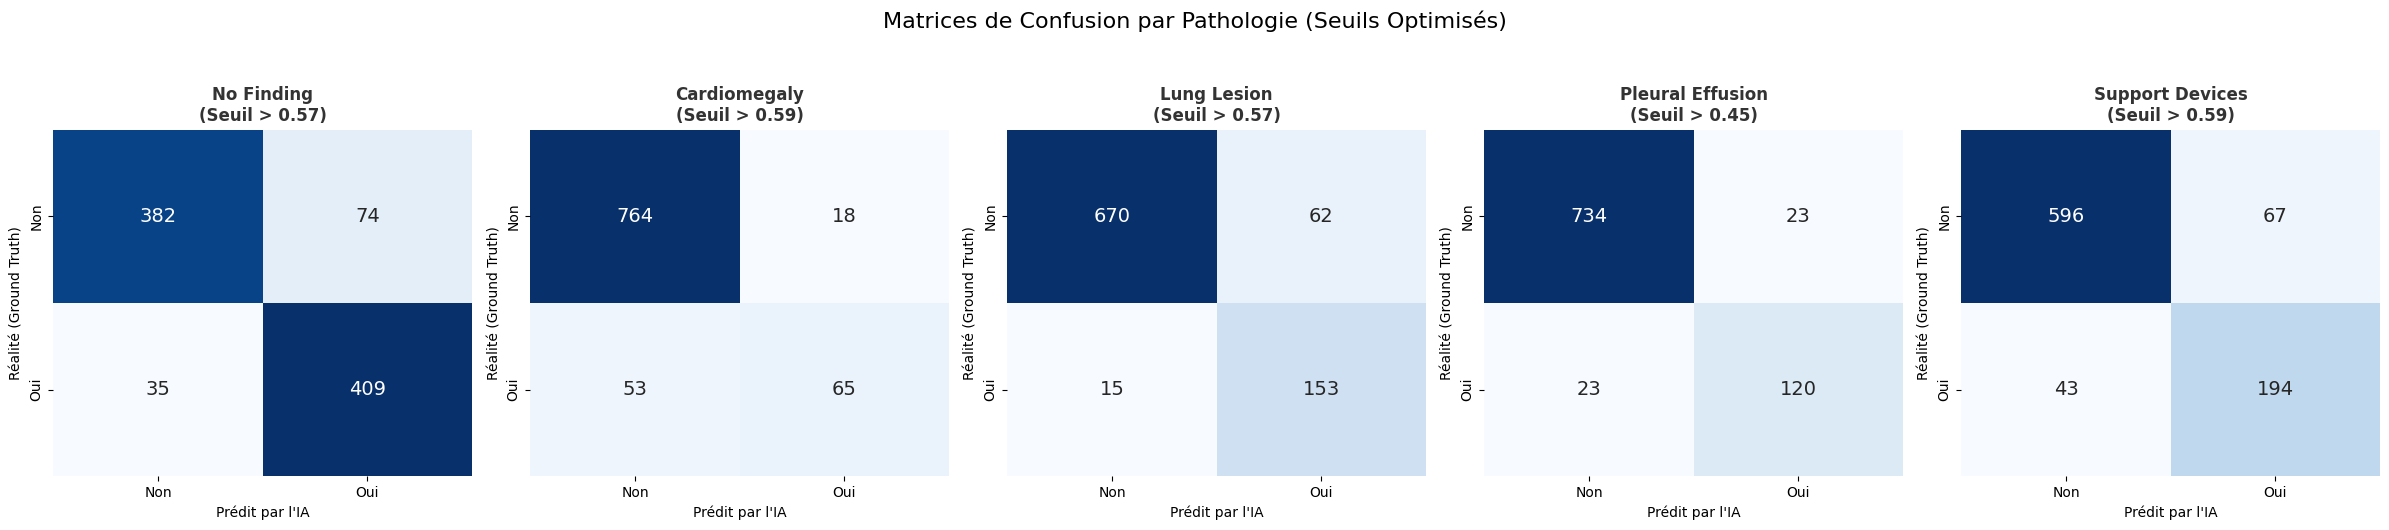

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch

# 1. VOS SEUILS OPTIMISÉS (Mis à jour avec vos résultats précédents)
# No Finding: 0.57 | Cardiomegaly: 0.59 | Lung Lesion: 0.57 | Pleural Effusion: 0.45 | Support Devices: 0.59
OPTIMAL_THRESHOLDS = [0.57, 0.59, 0.57, 0.45, 0.59]
CLASS_NAMES = ["No Finding", "Cardiomegaly", "Lung Lesion", "Pleural Effusion", "Support Devices"]

def visualize_final_metrics(model, dataloader, device, thresholds):
    model.eval()
    y_true_list = []
    y_probs_list = []

    print(f"📊 Calcul des métriques avec seuils optimisés : {thresholds}")

    with torch.no_grad():
        for img, ids, mask, labels in dataloader:
            img, ids, mask = img.to(device), ids.to(device), mask.to(device)

            # Utilisation de l'autocast pour être cohérent avec l'entraînement
            with torch.amp.autocast('cuda'):
                logits = model(img, ids, mask)
                probs = torch.sigmoid(logits)

            # .float() est important pour convertir le format Bfloat16/Half en Float32 pour Numpy
            y_probs_list.append(probs.cpu().float().numpy())
            y_true_list.append(labels.cpu().numpy())

    # Concaténation de tous les batches
    y_probs = np.concatenate(y_probs_list)
    y_true = np.concatenate(y_true_list).astype(int) # Assure que les vrais labels sont 0 ou 1

    # === APPLICATION DES SEUILS ===
    # On crée une matrice vide
    y_pred = np.zeros_like(y_probs, dtype=int)

    # On applique le seuil spécifique pour chaque colonne (classe)
    for i in range(len(thresholds)):
        y_pred[:, i] = (y_probs[:, i] >= thresholds[i]).astype(int)

    # --- 1. Rapport Textuel ---
    print("\n" + "="*60)
    print("RAPPORT DE CLASSIFICATION FINAL")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, zero_division=0))

    # --- 2. Matrices de Confusion Visuelles ---
    fig, axes = plt.subplots(1, 5, figsize=(24, 5))
    plt.suptitle("Matrices de Confusion par Pathologie (Seuils Optimisés)", fontsize=16, y=1.05)

    for i, class_name in enumerate(CLASS_NAMES):
        # Calcul de la matrice pour la classe i
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])

        # Affichage Heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i], annot_kws={"size": 14})

        # Esthétique
        axes[i].set_title(f"{class_name}\n(Seuil > {thresholds[i]})", fontsize=12, fontweight='bold', color='#333333')
        axes[i].set_xlabel("Prédit par l'IA")
        axes[i].set_ylabel("Réalité (Ground Truth)")
        axes[i].set_xticklabels(['Non', 'Oui'])
        axes[i].set_yticklabels(['Non', 'Oui'])

    plt.tight_layout()
    plt.show()

# Lancer l'analyse finale
visualize_final_metrics(model, val_dl, DEVICE, OPTIMAL_THRESHOLDS)

📊 Récupération des prédictions pour le traçage...


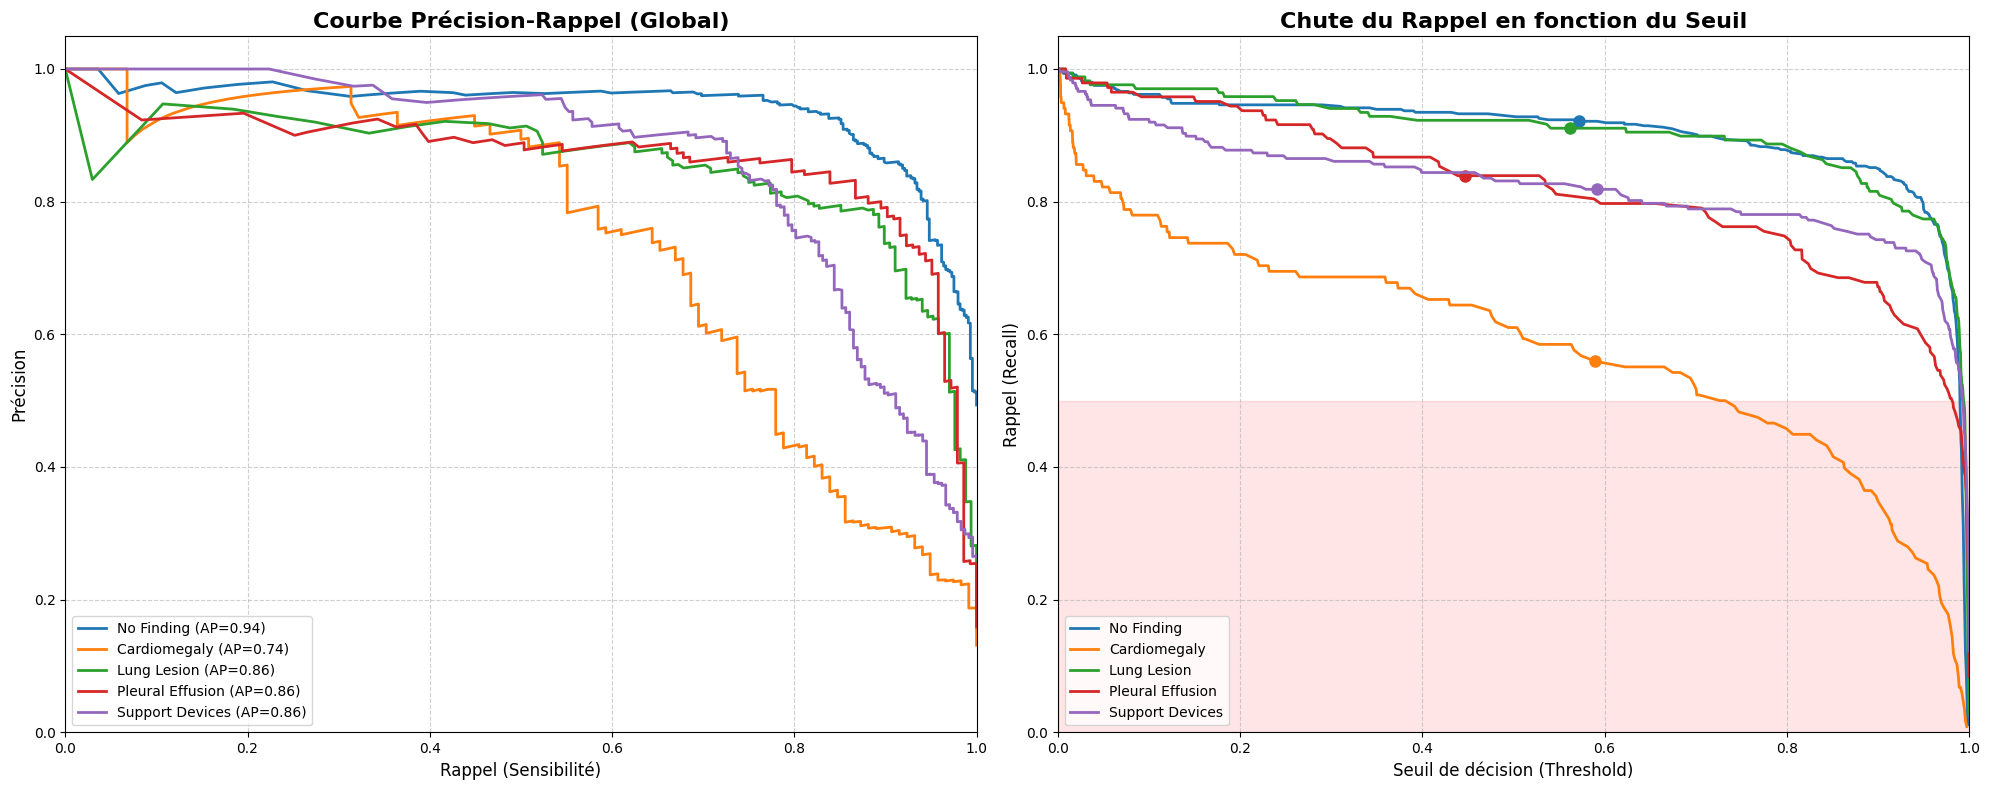

In [138]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_recall_curves(model, dataloader, device):
    model.eval()
    y_true_list = []
    y_probs_list = []

    print("📊 Récupération des prédictions pour le traçage...")

    # 1. Récupération des données
    with torch.no_grad():
        for img, ids, mask, labels in dataloader:
            img, ids, mask = img.to(device), ids.to(device), mask.to(device)
            with torch.amp.autocast('cuda'):
                logits = model(img, ids, mask)
                probs = torch.sigmoid(logits)

            y_probs_list.append(probs.cpu().float().numpy())
            y_true_list.append(labels.cpu().numpy())

    y_probs = np.concatenate(y_probs_list)
    y_true = np.concatenate(y_true_list).astype(int)

    # 2. Configuration des Graphiques
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    classes = ["No Finding", "Cardiomegaly", "Lung Lesion", "Pleural Effusion", "Support Devices"]

    # --- GRAPHIQUE 1 : PRECISION-RECALL CURVE (Standard) ---
    for i, class_name in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
        ap = average_precision_score(y_true[:, i], y_probs[:, i])

        ax1.plot(recall, precision, lw=2, color=colors[i], label=f'{class_name} (AP={ap:.2f})')

    ax1.set_title("Courbe Précision-Rappel (Global)", fontsize=16, fontweight='bold')
    ax1.set_xlabel("Rappel (Sensibilité)", fontsize=12)
    ax1.set_ylabel("Précision", fontsize=12)
    ax1.legend(loc="lower left")
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])

    # --- GRAPHIQUE 2 : EVOLUTION DU RAPPEL SELON LE SEUIL ---
    # C'est ce graphique qui aide à choisir le seuil (Threshold)
    for i, class_name in enumerate(classes):
        precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_probs[:, i])
        # On trace Rappel vs Seuil (Attention: thresholds est plus court de 1 élément que recall)
        ax2.plot(thresholds, recall[:-1], lw=2, color=colors[i], label=class_name)

        # Ajout d'un point pour montrer ton seuil optimal actuel
        current_threshold = OPTIMAL_THRESHOLDS[i] # Récupéré de ton code précédent
        # On trouve l'index le plus proche du seuil
        idx = (np.abs(thresholds - current_threshold)).argmin()
        ax2.plot(thresholds[idx], recall[idx], 'o', color=colors[i], markersize=8)

    ax2.set_title("Chute du Rappel en fonction du Seuil", fontsize=16, fontweight='bold')
    ax2.set_xlabel("Seuil de décision (Threshold)", fontsize=12)
    ax2.set_ylabel("Rappel (Recall)", fontsize=12)
    ax2.legend(loc="lower left")
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])

    # Zone de danger (Rappel trop faible)
    ax2.axhspan(0, 0.5, color='red', alpha=0.1, label="Zone Dangereuse (<50%)")

    plt.tight_layout()
    plt.show()

# Lancer le traçage
plot_recall_curves(model, val_dl, DEVICE)

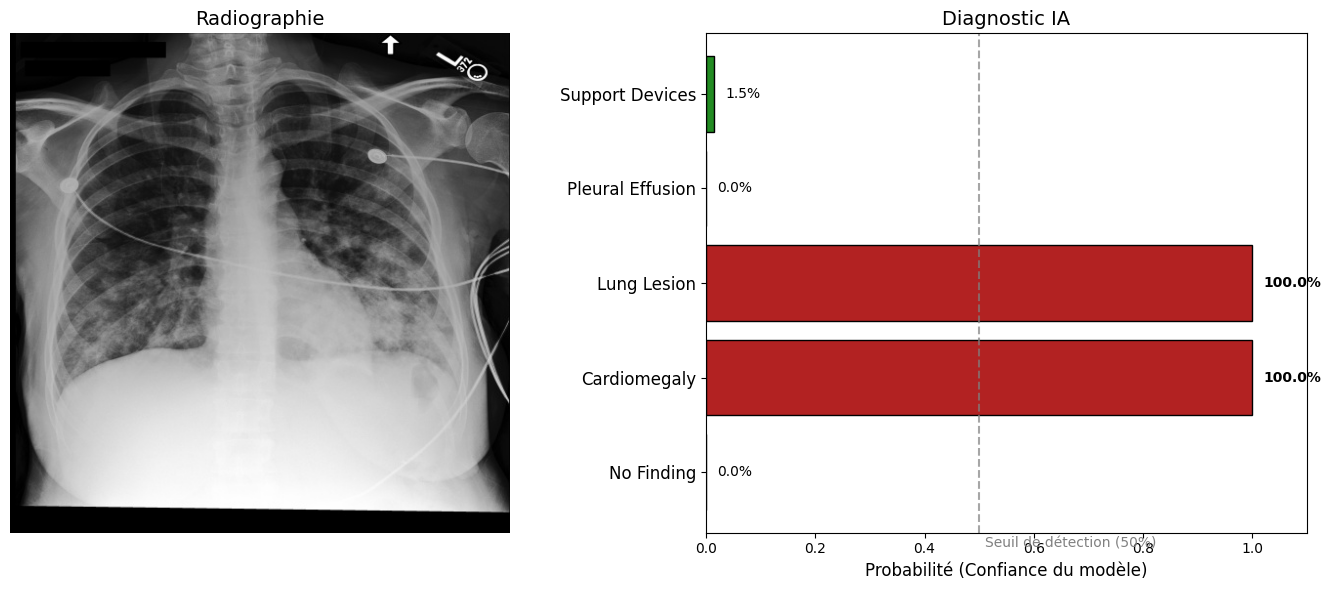

📄 Extrait du rapport :
                                 final report  examination:  chest (portable ap)    indication:  history: ___f with hypoxia  // r/o pe       recent d&c.    technique:  chest pa and lateral    comparison:  ___    findings:     heart size is normal.  the mediastinal and hilar contours are normal. the  pulmonary vasculature is normal.  bilateral multifocal pulmonary opacities are  demonstrated.  no pleural effusion or pneumothorax is seen.    impression:     multi focal opacities could represent septic emboli, aspiration or multifocal  pneumonia. recommend ct for further evaluation. 


In [116]:
from torchvision import transforms
from PIL import Image

def predict_single_patient(model, img_path, report_text, tokenizer, device):
    """
    Teste le modèle MultimodalModel sur un cas unique.
    """
    model.eval()

    # 1. Préparation de l'image (Mêmes transforms que validation)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:
        raw_img = Image.open(img_path).convert('RGB')
        img_tensor = transform(raw_img).unsqueeze(0).to(device) # Ajout dimension Batch [1, 3, 224, 224]
    except Exception as e:
        print(f"❌ Erreur lors du chargement de l'image : {e}")
        return

    # 2. Préparation du texte
    # Nettoyage sommaire
    clean_text = report_text.lower().replace("\n", " ")

    encoding = tokenizer(clean_text, truncation=True, padding='max_length',
                         max_length=MAX_LEN, return_tensors='pt')

    ids = encoding['input_ids'].to(device)
    mask = encoding['attention_mask'].to(device)

    # 3. Prédiction
    with torch.no_grad():
        # Appel au modèle
        logits = model(img_tensor, ids, mask)
        probs = torch.sigmoid(logits).cpu().numpy()[0] # Récupérer le vecteur de probas

    # 4. Affichage Graphique
    plt.figure(figsize=(14, 6))

    # -- Image --
    plt.subplot(1, 2, 1)
    plt.imshow(raw_img)
    plt.axis('off')
    plt.title("Radiographie", fontsize=14)

    # -- Barres de Probabilités --
    plt.subplot(1, 2, 2)
    y_pos = np.arange(len(CLASS_NAMES))

    # Couleur : Rouge si > 50%, Vert sinon
    colors = ['firebrick' if p >= 0.5 else 'forestgreen' for p in probs]

    bars = plt.barh(y_pos, probs, color=colors, edgecolor='black')

    plt.yticks(y_pos, CLASS_NAMES, fontsize=12)
    plt.xlim(0, 1.1)
    plt.xlabel("Probabilité (Confiance du modèle)", fontsize=12)
    plt.title("Diagnostic IA", fontsize=14)

    # Ligne de seuil à 50%
    plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7)
    plt.text(0.51, -0.8, 'Seuil de détection (50%)', color='gray', fontsize=10)

    # Afficher les pourcentages
    for i, v in enumerate(probs):
        score_text = f"{v*100:.1f}%"
        font_weight = 'bold' if v >= 0.5 else 'normal'
        plt.text(v + 0.02, i, score_text, va='center', fontweight=font_weight)

    plt.tight_layout()
    plt.show()

    print(f"📄 Extrait du rapport :\n{clean_text}")


# === EXEMPLE D'UTILISATION ===

# Choisissons un patient au hasard dans le DataFrame de validation
import random
random_idx = random.randint(0, len(val_df) - 1)
sample = val_df.iloc[random_idx]

img_path_test = sample['img_path']
report_test = sample['report']

# Lancer la prédiction
predict_single_patient(model, img_path_test, report_test, tokenizer, DEVICE)

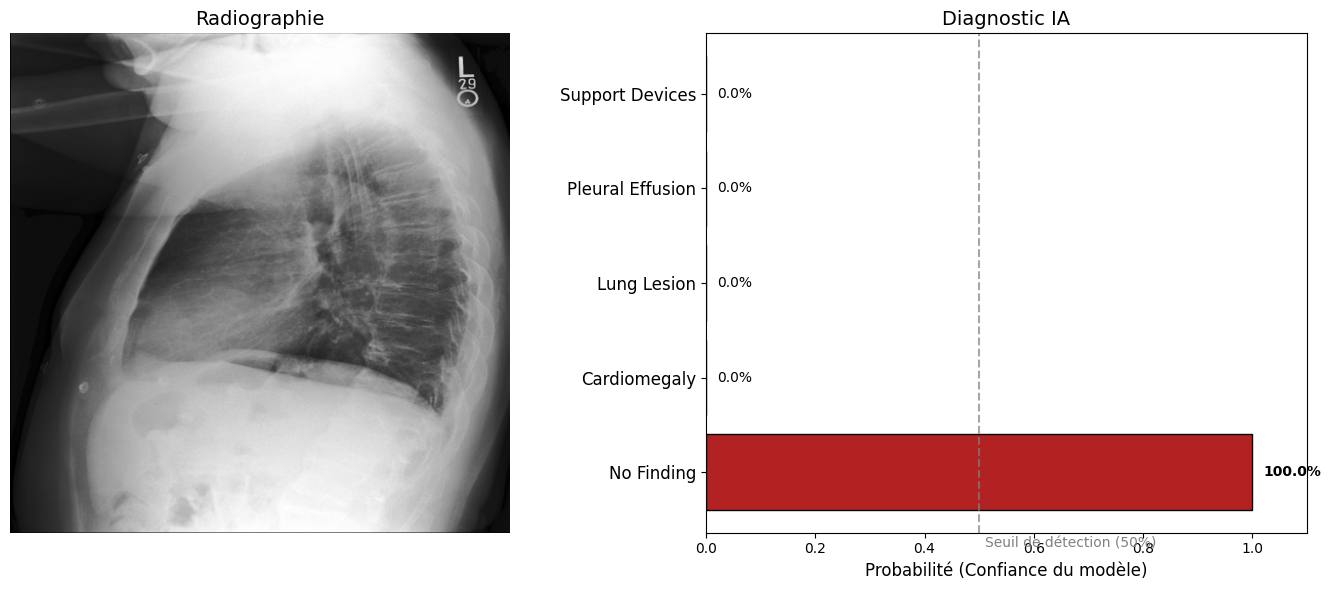

📄 Extrait du rapport :
                                 final report  exam:  chest frontal and lateral views.    clinical information:  bilateral shoulder pain.    comparison:  ___.    findings:  frontal and lateral views of the chest were obtained.  lungs are  clear without focal consolidation.  no pleural effusion or pneumothorax is  seen.  the cardiac and mediastinal silhouettes are stable and unremarkable.   the shoulder joints are not fully imaged.    degenerative changes are seen along the spine.    impression:  no acute cardiopulmonary process. 


In [111]:
from torchvision import transforms
from PIL import Image

def predict_single_patient(model, img_path, report_text, tokenizer, device):
    """
    Teste le modèle MultimodalModel sur un cas unique.
    """
    model.eval()

    # 1. Préparation de l'image (Mêmes transforms que validation)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:
        raw_img = Image.open(img_path).convert('RGB')
        img_tensor = transform(raw_img).unsqueeze(0).to(device) # Ajout dimension Batch [1, 3, 224, 224]
    except Exception as e:
        print(f"❌ Erreur lors du chargement de l'image : {e}")
        return

    # 2. Préparation du texte
    # Nettoyage sommaire
    clean_text = report_text.lower().replace("\n", " ")

    encoding = tokenizer(clean_text, truncation=True, padding='max_length',
                         max_length=MAX_LEN, return_tensors='pt')

    ids = encoding['input_ids'].to(device)
    mask = encoding['attention_mask'].to(device)

    # 3. Prédiction
    with torch.no_grad():
        # Appel au modèle
        logits = model(img_tensor, ids, mask)
        probs = torch.sigmoid(logits).cpu().numpy()[0] # Récupérer le vecteur de probas

    # 4. Affichage Graphique
    plt.figure(figsize=(14, 6))

    # -- Image --
    plt.subplot(1, 2, 1)
    plt.imshow(raw_img)
    plt.axis('off')
    plt.title("Radiographie", fontsize=14)

    # -- Barres de Probabilités --
    plt.subplot(1, 2, 2)
    y_pos = np.arange(len(CLASS_NAMES))

    # Couleur : Rouge si > 50%, Vert sinon
    colors = ['firebrick' if p >= 0.5 else 'forestgreen' for p in probs]

    bars = plt.barh(y_pos, probs, color=colors, edgecolor='black')

    plt.yticks(y_pos, CLASS_NAMES, fontsize=12)
    plt.xlim(0, 1.1)
    plt.xlabel("Probabilité (Confiance du modèle)", fontsize=12)
    plt.title("Diagnostic IA", fontsize=14)

    # Ligne de seuil à 50%
    plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7)
    plt.text(0.51, -0.8, 'Seuil de détection (50%)', color='gray', fontsize=10)

    # Afficher les pourcentages
    for i, v in enumerate(probs):
        score_text = f"{v*100:.1f}%"
        font_weight = 'bold' if v >= 0.5 else 'normal'
        plt.text(v + 0.02, i, score_text, va='center', fontweight=font_weight)

    plt.tight_layout()
    plt.show()

    print(f"📄 Extrait du rapport :\n{clean_text}")


# === EXEMPLE D'UTILISATION ===

# Choisissons un patient au hasard dans le DataFrame de validation
import random
random_idx = random.randint(0, len(val_df) - 1)
sample = val_df.iloc[random_idx]

img_path_test = sample['img_path']
report_test = sample['report']

# Lancer la prédiction
predict_single_patient(model, img_path_test, report_test, tokenizer, DEVICE)

In [ ]:
import json

# 1. Sauvegarder Modèle + Seuils
checkpoint = {
    'model_state_dict': model.state_dict(),
    'thresholds': OPTIMAL_THRESHOLDS,
    'class_names': CLASS_NAMES
}

torch.save(checkpoint, "mimic_model_complete.pth")
print("✅ Modèle complet (poids + seuils) sauvegardé sous 'mimic_model_complete.pth'")

# Sauvegarder aussi les seuils en JSON pour lecture facile
with open("thresholds.json", "w") as f:
    json.dump({"thresholds": OPTIMAL_THRESHOLDS, "classes": CLASS_NAMES}, f)

✅ Modèle complet (poids + seuils) sauvegardé sous 'mimic_model_complete.pth'
